In [1]:
# Import required libraries
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import json
from pathlib import Path

# Import DetectionMetrics components
from detectionmetrics.datasets.coco import CocoDataset
from detectionmetrics.models.torch_detection import TorchImageDetectionModel
from detectionmetrics.utils import conversion as uc

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Create directories for data
!mkdir -p local/data/models
!mkdir -p local/outputs

In [3]:
# Initialize COCO dataset
# Using existing COCO data paths
img_dir = "/Users/sakprave/Downloads/Coco/images/train2017"
ann_file = "/Users/sakprave/Downloads/Coco/annotations/instances_train2017.json"

# Check if files exist
if not os.path.exists(img_dir) or not os.path.exists(ann_file):
    print("COCO data not found. Please check the paths above.")
else:
    # Load dataset
    dataset = CocoDataset(annotation_file=ann_file, image_dir=img_dir)
    print(f"Dataset loaded with {len(dataset.dataset)} samples")
    print(f"Number of classes: {len(dataset.ontology)}")

loading annotations into memory...
Done (t=7.43s)
creating index...
index created!
Dataset loaded with 118287 samples
Number of classes: 80


In [4]:
# Create a pre-trained detection model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# Save the model
model_path = "local/data/models/maskrcnn_model.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model, model_path)
model_cfg = {
    "batch_size": 1,
    "num_workers": 0,
    "confidence_threshold": 0.8,
    "nms_threshold": 0.3
}
config_path = "local/data/models/maskrcnn_config.json"
with open(config_path, "w") as f:
    json.dump(model_cfg, f, indent=2)

# Save model ontology
class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]
model_ontology = {}
for i, name in enumerate(class_names):
    model_ontology[str(i + 1)] = {
        "idx": i + 1,
        "name": name,
        "rgb": [0, 0, 0]
    }
ontology_path = "local/data/models/coco_model_ontology.json"
with open(ontology_path, "w") as f:
    json.dump(model_ontology, f, indent=2)

# dataset.ontology uses class names as keys
ontology_translation = {}
for name, data in dataset.ontology.items():
    for idx, model_data in model_ontology.items():
        if model_data["name"] == name:
            ontology_translation[name] = idx
            break

# Save ontology translation
translation_path = "local/data/models/ontology_translation.json"
with open(translation_path, "w") as f:
    json.dump(ontology_translation, f, indent=2)

print("Model and configuration saved!")

Model and configuration saved!


In [5]:
detection_model = TorchImageDetectionModel(
    model=model_path,
    model_cfg=config_path,
    ontology_fname=ontology_path  # This is the model ontology (indices as keys)
)

# Set ontology and number of classes
detection_model.ontology = model_ontology 
detection_model.n_classes = len(model_ontology)

print("Detection model initialized!")

Model is not a TorchScript model. Loading as native PyTorch model.
Detection model initialized!


In [6]:
# Function to visualize detection results
def visualize_detections(image, predictions, ground_truth=None, title="Detection Results"):
    """Visualize detection predictions and optionally ground truth."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Display image
    ax.imshow(image)
    
    #map labels to class names
    label_to_name = {v['idx'] : v['name'] for k,v in dataset.ontology.items()}

    # Draw prediction boxes
    if predictions and isinstance(predictions, dict) and 'boxes' in predictions:
        boxes = predictions['boxes'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()
        
        for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Get class name
            class_name = label_to_name.get(label, str(label))
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)
            
            # Add label
            ax.text(x1, y1-5, f'{class_name}: {score:.2f}', 
                   color='red', fontsize=10, weight='bold')
    
    # Draw ground truth boxes (if provided)
    if ground_truth and isinstance(ground_truth, tuple) and len(ground_truth) >= 2:
        gt_boxes, gt_labels = ground_truth
        
        for i, (box, label) in enumerate(zip(gt_boxes, gt_labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Get class name
            class_name = label_to_name.get(label, str(label))
            
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)
            
            ax.text(x1, y1+height+5, f'GT: {class_name}', 
                   color='green', fontsize=10, weight='bold')
    
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

 Testing inference on: /Users/sakprave/Downloads/Coco/images/train2017/000000391895.jpg
   Image size: (640, 360)


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x469d60510>
    label = <none> 
    device = <AGXG13XDevice: 0x3d06a1200>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x41137b800>
        label = <none> 
        device = <AGXG13XDevice: 0x3d06a1200>
            name = Apple M1 Pro 
    retainedReferences = 1


 Found 2 detections
 Ground truth: 4 objects


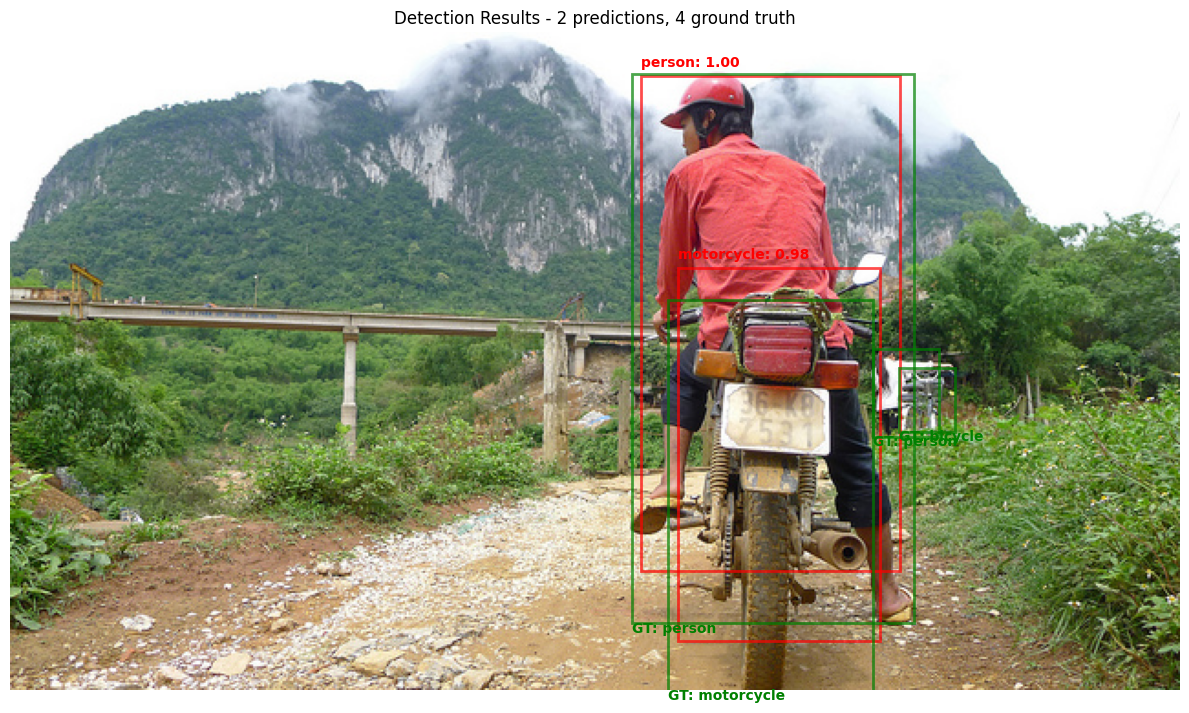

In [7]:
# Test inference on a single image
if 'dataset' in locals() and len(dataset.dataset) > 0:
    # Make filenames global first
    dataset.make_fname_global()
    
    # Get first image from dataset
    sample_idx = 0
    image_path = dataset.dataset.iloc[sample_idx]['image']
    
    # Load and display original image
    image = Image.open(image_path).convert('RGB')
    print(f" Testing inference on: {image_path}")
    print(f"   Image size: {image.size}")
    
    # Run inference
    predictions = detection_model.inference(image)
    
    print(f" Found {len(predictions['boxes'])} detections")
    # Get ground truth for comparison
    annotation_path = dataset.dataset.iloc[sample_idx]['annotation']
    ground_truth = dataset.read_annotation(annotation_path)
    
    print(f" Ground truth: {len(ground_truth[0])} objects")
    
    # Visualize results
    visualize_detections(
        np.array(image), 
        predictions, 
        ground_truth,
        title=f"Detection Results - {len(predictions['boxes'])} predictions, {len(ground_truth[0])} ground truth"
    )
else:
    print(" Dataset not loaded. Please check the data paths above.")

In [10]:
# Run evaluation on a subset of the dataset
# For demonstration, we'll use a small subset
if 'dataset' in locals():
    
    # Create a small subset for faster evaluation
    small_dataset = dataset.dataset.head(5) 
    # small_dataset = dataset.dataset.iloc[10:15]  # Selects rows with indices 
    
    # Temporarily replace dataset with subset
    original_dataset = dataset.dataset
    dataset.dataset = small_dataset
    
    # dataset.dataset_dir = "/Users/sakprave/Downloads/Coco"
    
    # Make sure the output directory exists
    predictions_outdir = "local/outputs/detection_preds"
    os.makedirs(predictions_outdir, exist_ok=True)
    
    # Path to ontology translation file
    ontology_translation_path = "local/data/models/ontology_translation.json"
    
    try:
        # Run evaluation with ontology translation
        results = detection_model.eval(
            dataset=dataset,
            split="train",  # Use train split for demo
            ontology_translation=ontology_translation_path,  # Add ontology translation
            predictions_outdir=predictions_outdir,
            results_per_sample=True
        )
        
        print(" Evaluation completed!")
        
    except Exception as e:
        print(f" Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Restore original dataset
        dataset.dataset = original_dataset
        # Reset dataset_dir back to None (as it was after make_fname_global)
        dataset.dataset_dir = None
else:
    print("  Dataset not loaded. Please check the data paths above.")


  0%|          | 0/5 [00:00<?, ?it/s]

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x46af9c340>
    label = <none> 
    device = <AGXG13XDevice: 0x3d06a1200>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x41137b800>
        label = <none> 
        device = <AGXG13XDevice: 0x3d06a1200>
            name = Apple M1 Pro 
    retainedReferences = 1


---- DetectionMetricsFactory.update ----
GT boxes: [[359.17 146.17 471.62 359.74]
 [339.88  22.16 493.76 322.89]
 [471.64 172.82 507.56 220.92]
 [486.01 183.31 516.64 218.29]]
GT labels: [4 1 1 2]
Pred boxes: [[344.64523   23.655207 486.41135  294.1324  ]
 [364.82397  128.32848  475.58408  332.32275 ]]
Pred labels: [1 4]
Pred scores: [0.997053   0.98065954]
----------------------------------------
IoU matrix:
 [[3.63902314e-01 8.28598431e-01 1.80505436e-02 3.56296457e-04]
 [7.43747752e-01 4.55392034e-01 7.86116442e-03 0.00000000e+00]]
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 4 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 1 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 1 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 2 (type <class 'numpy.int64'>)
Pred 0 (label 1): max_iou=0.8285984305725937, max_j=1, threshold=0.5
Co

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x47369e150>
    label = <none> 
    device = <AGXG13XDevice: 0x3d06a1200>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x41137b800>
        label = <none> 
        device = <AGXG13XDevice: 0x3d06a1200>
            name = Apple M1 Pro 
    retainedReferences = 1


---- DetectionMetricsFactory.update ----
GT boxes: [[382.48   0.   639.28 474.31]
 [234.06 406.61 454.   449.28]
 [  0.   316.04 406.65 473.53]
 [305.45 172.05 362.81 249.35]]
GT labels: [ 1 44 56 72]
Pred boxes: [[400.47192   35.092403 633.63306  480.00003 ]
 [237.75032  406.89633  451.5188   448.94592 ]
 [  4.900365 314.2735   448.3876   470.4654  ]]
Pred labels: [ 1 49 65]
Pred scores: [0.98050356 0.94593316 0.8530698 ]
----------------------------------------
IoU matrix:
 [[0.83171351 0.02060742 0.00583305 0.        ]
 [0.02269985 0.95780804 0.10772274 0.        ]
 [0.05694415 0.13157168 0.87047207 0.        ]]
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 1 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 44 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 56 (type <class 'numpy.int64'>)
Comparing pred label 1 (type <class 'numpy.int64'>) with gt label 72 (type <class 'n

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x47c91e1f0>
    label = <none> 
    device = <AGXG13XDevice: 0x3d06a1200>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x41137b800>
        label = <none> 
        device = <AGXG13XDevice: 0x3d06a1200>
            name = Apple M1 Pro 
    retainedReferences = 1


---- DetectionMetricsFactory.update ----
GT boxes: [[239.9  111.16 368.52 210.87]
 [285.08  85.99 455.31 150.47]
 [452.49  85.93 500.   108.75]
 [296.96  68.01 319.35  89.07]
 [461.07  75.92 495.53  90.11]
 [103.44  31.01 258.23 166.16]
 [ 65.33  59.84  85.97  72.15]
 [146.48  65.69 307.31 312.59]
 [  8.29  57.26  83.62 204.16]
 [ 45.24  48.41  91.21 173.96]
 [ 20.71  44.87  64.99  95.23]
 [  0.75  76.59  36.91 182.06]
 [343.28  63.97 362.24  92.7 ]
 [362.05  66.51 379.49  91.29]
 [382.76  60.79 395.58  93.33]
 [413.61  61.01 425.53  88.21]
 [314.34  57.09 328.03  88.82]
 [288.04  57.1  297.8   86.81]
 [272.72  56.58 279.09  87.12]
 [  8.93  48.6   18.1   59.29]
 [271.13  87.59 349.22 110.6 ]
 [257.75  80.2  287.42 110.87]
 [255.71 132.65 493.09 317.67]
 [  0.    35.   481.   185.  ]]
GT labels: [20 20 20 20 20 26 20  1  1  1  1  1  1  1  1  1  1  1  1  1 20 20 20  1]
Pred boxes: [[2.19201412e+01 5.53035049e+01 8.21353455e+01 2.00806656e+02]
 [1.04917175e+02 3.24059181e+01 2.62389099e+

In [11]:
display(results)

,1,2,3,4,5,6,7,8,9,10,...,73,74,75,76,77,78,79,80,mean,mAP
AP,0.353535,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.095960,0.09596
Precision,0.750000,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.171875,NaN
Recall,0.375000,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.092882,NaN
TP,9.000000,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.687500,NaN
FP,3.000000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,1.187500,NaN
FN,15.000000,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,3.187500,NaN
